In [1]:
%load_ext autoreload
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # high res plotting

import pickle
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp, pearsonr, spearmanr
import statsmodels.formula.api as smf

# plotting stuff
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import echo_utils

# # plot settings
# font = {'family' : 'Bitstream Vera Sans',
#         'weight' : 'regular',
#         'size'   : 13}
# figure = {'figsize' : (16,8)}

# matplotlib.rc('font', **font)
# matplotlib.rc('figure', **figure)


### Single-trial fits (mine)

Ttest_1sampResult(statistic=7.047812909066132, pvalue=8.698888318293546e-06)
                            OLS Regression Results                            
Dep. Variable:                    acc   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     7.648
Date:                Fri, 29 Nov 2019   Prob (F-statistic):            0.00828
Time:                        13:03:48   Log-Likelihood:                 23.924
No. Observations:                  14   AIC:                            -41.85
Df Residuals:                      11   BIC:                            -39.93
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less_equal
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in less_equal
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in less_equal
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: Mean of 

,age,sex,acc_identity,acc_spatial,acc_temporal,rt_identity,rt_spatial,rt_temporal,sampling_rate,data_qual,pre,enc,diff,tvals,acc,rt
patient,,,,,,,,,,,,,,,,
s1,33.0,F,0.900,0.950,0.850,1947.968750,1844.540541,1556.852941,1000,64.033264,0.030454,0.030461,0.002378,1.291967,0.900000,1783.120744
s2,50.0,M,0.950,0.975,0.975,1155.111111,1092.236842,1169.378378,1000,44.395280,0.032536,0.035559,0.003399,1.378578,0.966667,1138.908777
s4,31.0,M,0.925,0.925,0.950,1562.411765,1740.277778,2069.567568,1000,42.675545,0.041418,0.043580,0.006692,3.566740,0.933333,1790.752370
s5,22.0,M,0.825,0.800,0.750,3174.531250,2535.322581,3142.178571,1000,42.596154,0.036455,0.038350,0.003180,1.802413,0.791667,2950.677467
s6,31.0,M,0.925,1.000,0.925,1685.702703,962.925000,1088.351351,1000,27.797478,0.046700,0.048500,0.003814,2.252581,0.950000,1245.659685
s7,34.0,M,0.900,1.000,0.975,779.371429,740.131579,647.594595,1000,50.136364,0.026343,0.028637,0.004582,2.630699,0.958333,722.365867
s8,27.0,M,0.900,0.975,0.975,1469.166667,1037.076923,989.282051,512,25.277778,0.036947,0.052307,0.024204,3.217615,0.950000,1165.175214
s9,34.0,F,0.875,0.825,0.825,1700.057143,1308.848485,1797.484848,512,76.628788,0.020598,0.021271,0.000461,0.548537,0.841667,1602.130159
s10,42.0,M,0.875,0.975,0.925,869.800000,661.297297,811.352941,1000,41.911225,0.041177,0.042723,0.003434,2.492233,0.925000,780.816746


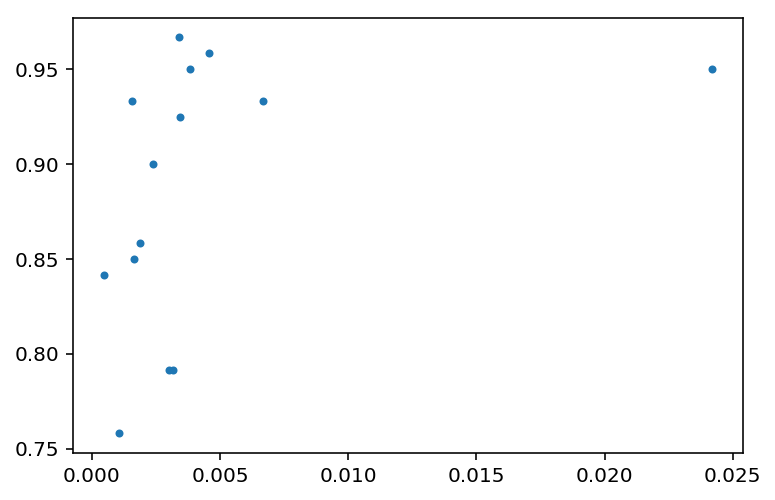

In [209]:
# load metadata
df_patient_info = pd.read_csv('../data/df_johnson_patient_info.csv', index_col=0)
result_path = '../data/johnson/'

# load data
with open(result_path + "all_exp.txt", "rb") as fp: # unpickling
    all_exp = pickle.load(fp)
with open(result_path + "all_offset.txt", "rb") as fp: # unpickling
    all_offset = pickle.load(fp)
with open(result_path + "all_knee.txt", "rb") as fp: # unpickling
    all_knee = pickle.load(fp)
with open(result_path + "all_tau.txt", "rb") as fp: # unpickling
    all_tau = pickle.load(fp)

feature = all_tau
axis = 0 # 0 to mean across channels, 1 to mean across trials

grand_avg = []

for i_p in range(len(df_patient_info)):
    # remove bad fits if exp<0 or knee<0
    feature[i_p][(all_exp[i_p]<0) | (all_knee[i_p]<=0)] = np.nan
   # feature[i_p][(all_tau[i_p]<0)| (all_tau[i_p]>0.5)] = np.nan
    
    # get prestim, encoding, and difference per trial
    prestim = feature[i_p][0,:,:]
    encoding  = (feature[i_p][1,:,:]+feature[i_p][2,:,:])/2
    
    encoding[encoding <= 0] = np.nan
    prestim[prestim <= 0] = np.nan
    encoding[encoding > 0.5] = np.nan
    prestim[prestim > 0.5] = np.nan
    
    d_enc_pre = encoding - prestim
    
    mean_pre = np.nanmean(prestim,axis)
    mean_enc = np.nanmean(encoding,axis)
    mean_d = np.nanmean(d_enc_pre,axis)
    
    # t-test on mean difference
    tval, pv = ttest_1samp(mean_d, popmean=0, nan_policy='omit')
    
    # collect results
    grand_avg.append([(1-np.isnan(d_enc_pre).sum()/np.prod(d_enc_pre.shape))*100, 
                      np.nanmean(mean_pre), np.nanmean(mean_enc), np.nanmean(mean_d), tval])

df_result = pd.DataFrame(np.array(grand_avg), index=df_patient_info.index, columns=['data_qual', 'pre', 'enc', 'diff', 'tvals'])

# s3 has really bad data, s15 & s17 are same as s5 & s8
valid_pat = df_patient_info.index[[0,1,3,4,5,6,7,8,9,10,11,12,13,15]].values 
df_patient = pd.concat((df_patient_info, df_result), axis=1)
df_patient['acc'] = df_patient[['acc_identity','acc_spatial','acc_temporal']].mean(1)
df_patient['rt'] = df_patient[['rt_identity','rt_spatial','rt_temporal']].mean(1)

df_patient = df_patient.loc[valid_pat]
print(ttest_1samp(df_patient['tvals'], 0, nan_policy='omit'))
mod = smf.ols(formula='acc ~ age + diff', data=df_patient)
res = mod.fit()
print(res.summary())

plt.plot(df_patient['diff'],df_patient['acc'], '.')
#plt.xlim([0, 0.01])
df_patient

In [198]:
d_enc_pre

array([[        nan,  0.1985849 ,         nan,  0.34586802,  0.01583609,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,  0.00738133,         nan,
                nan,         nan,         nan,  0.04251738,  0.02877257,
        -0.00688805,         nan,         nan,         nan, -0.02828614,
         0.02396045,         nan,  0.01310939,         nan,         nan,
                nan,         nan,         nan,  0.08756918, -0.07651045,
                nan,         nan,         nan,         nan,         nan,
        -0.00691072,         nan,  0.02615519,  0.01290527,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,  0.06308752,         nan,         nan,         nan,
         0.00722717,  0.00756007,         nan,         nan,         nan,
        -0.01494266, -0.01310432,         nan,         nan,         nan,
                nan,         nan,         nan,     

# Reproducing using Brad's fits

In [183]:
# load data
with open("../notebooks/Johnson/all_exp.txt", "rb") as fp: # unpickling
    all_exp = pickle.load(fp)
# with open("../notebooks/Johnson/all_offset.txt", "rb") as fp: # unpickling
#     all_offset = pickle.load(fp)
with open("../notebooks/Johnson/all_kfq.txt", "rb") as fp: # unpickling
    all_kfreq = pickle.load(fp)
with open("../notebooks/Johnson/all_tau.txt", "rb") as fp: # unpickling
    all_tau = pickle.load(fp)
    
feature = all_tau
axis = 0 # 0 to mean across channels, 1 to mean across trials

t_vals, p_vals = [], []
grand_avg = []
for i_p in range(len(df_patient_info)-1):    
    # get prestim, encoding, and difference per trial
    prestim = feature[i_p][0,:,:]
    encoding  = (feature[i_p][1,:,:]+feature[i_p][2,:,:])/2
    
    encoding[encoding <= 0] = np.nan
    prestim[prestim <= 0] = np.nan
    encoding[encoding > 0.5] = np.nan
    prestim[prestim > 0.5] = np.nan
    
    d_enc_pre = encoding - prestim
    
    mean_pre = np.nanmean(prestim,axis)
    mean_enc = np.nanmean(encoding,axis)
    mean_d = np.nanmean(d_enc_pre,axis)
    
    # t-test on mean difference
    tval, pv = ttest_1samp(mean_d, popmean=0, nan_policy='omit')
    grand_avg.append([np.nanmean(mean_pre), np.nanmean(mean_enc), np.nanmean(mean_d), tval])
    t_vals.append(tval)
    p_vals.append(pv)

#df_result = pd.DataFrame(np.array(grand_avg), index=df_patient_info.index, columns=['pre', 'enc', 'diff', 'tvals'])
df_result = pd.DataFrame(np.array(grand_avg), index=df_patient_info.index[[0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16]], columns=['pre', 'enc', 'diff', 'tvals'])

valid_pat = df_patient_info.index[[0,1,3,4,5,6,7,8,9,10,11,12,13,15]].values # s3 has really bad data, s15 & s17 are same as s5 & s8
df_patient = pd.concat((df_patient_info, df_result), axis=1)
df_patient['acc'] = df_patient[['acc_identity','acc_spatial','acc_temporal']].mean(1)
df_patient['rt'] = df_patient[['rt_identity','rt_spatial','rt_temporal']].mean(1)
df_patient = df_patient.loc[valid_pat]
print(ttest_1samp(df_patient['tvals'], 0, nan_policy='omit'))

mod = smf.ols(formula='acc ~ age + diff', data=df_patient)
res = mod.fit()
print(res.summary())


Ttest_1sampResult(statistic=4.64264145422118, pvalue=0.00046062259763812654)
                            OLS Regression Results                            
Dep. Variable:                    acc   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     9.807
Date:                Thu, 28 Nov 2019   Prob (F-statistic):            0.00359
Time:                        16:34:15   Log-Likelihood:                 24.988
No. Observations:                  14   AIC:                            -43.98
Df Residuals:                      11   BIC:                            -42.06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less_equal
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less_equal
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is n

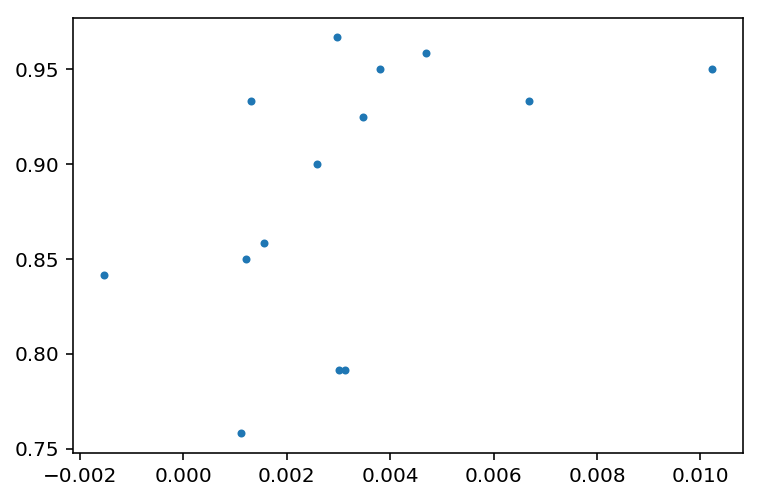

In [185]:
plt.plot(df_patient['diff'],df_patient['acc'], '.')

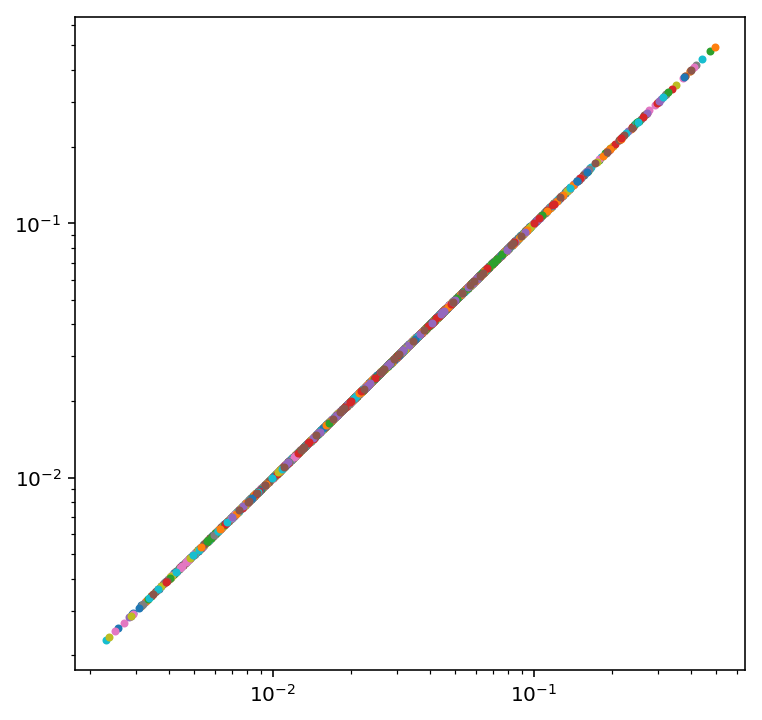

In [191]:
#bv_all_tau = all_tau
with open("../notebooks/Johnson/all_tau.txt", "rb") as fp: # unpickling
    bv_all_tau = pickle.load(fp)

plt.figure(figsize=(6,6))
cond=0
subj=-8
plt.plot(bv_all_tau[subj][cond], all_tau[subj][cond], '.');
#df_patient.index[-8]

In [194]:
all_tau

[array([[[       nan, 0.01062263, 0.01118819, ..., 0.00658618,
          0.00657521, 0.02446878],
         [0.00666273, 0.01892358, 0.00488353, ..., 0.04222276,
          0.00754101, 0.01624006],
         [0.00838021,        nan, 0.00544218, ..., 0.04481602,
          0.01007631, 0.01379476],
         ...,
         [0.01663331, 0.02048147, 0.00441489, ..., 0.00557668,
          0.00703279, 0.02290868],
         [0.01815044, 0.02212425, 0.03181135, ..., 0.02640274,
          0.07293245, 0.02491022],
         [0.02558703, 0.01543443, 0.00743301, ..., 0.02234141,
          0.01943496, 0.00851247]],
 
        [[0.00363532, 0.01110497, 0.01306794, ..., 2.18462338,
          0.00575535, 0.00500063],
         [0.05757515, 0.00605693,        nan, ..., 0.00905366,
          0.00574139, 0.01251635],
         [       nan, 0.01752722, 0.1540081 , ..., 0.03030747,
          0.03196186, 0.09033974],
         ...,
         [0.00412968, 0.00596408, 0.01314917, ..., 0.01559453,
                 nan, 0.

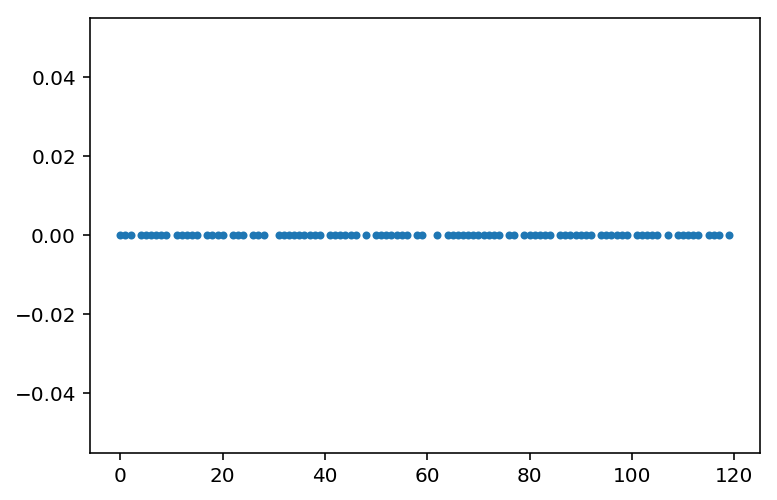

In [193]:
subj, cond, chan = -4, 1, 2
#plt.loglog(bv_all_tau[-2][cond,chan], all_tau[-2][cond,chan], '.')
#plt.plot(plt.xlim(),plt.ylim(), '--')
plt.plot(bv_all_tau[subj][cond,chan]-all_tau[subj][cond,chan], '.')